In [1]:
TEST = True
DROPNA = True
NSUBS = 10000
TESTSUBS = 10000
MINSTUDENTS = 30
MINITEMS = 30

In [2]:
import pyreadr
import os
import pandas as pd
from datetime import datetime
import numpy as np
from utils import mymode
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Definitions

COLS = [
    'studentId',
    'assessmentId',
    'class',
    'code',
    'grade',
    'Gender',
    'candidateResponses',
    'useCase',
    'motherTongue',
    'age',
    'scale',
    'timestamp',
    'timestamp_2',
    'timeOpened',
    'timeClosed',
    'viewingTime',
    'matrix',
    'IRT_difficulty',
    'score'
  ]


In [3]:
STUDENT_COLS = ['studentId', 'motherTongue', 'Gender']
ITEM_COLS = ['code', 'scale', 'matrix', 'IRT_difficulty', 'topic', 'responseformat', 'textlength']
EDGE_COLS = ['score', 'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId'] #, 'timestamp'

MAINCOLS = ['studentId', 'motherTongue', 'Gender', 'code', 'scale', 'score', 'age', 'grade'] 

DATA_PATH = './data/dd_2023_Jan_valid_parameters.rds'
TEST_PATH = './data/dd_2023_Jan_valid_test_%d.csv'%TESTSUBS
#TEST_PATH = './data/dd_2023_Jan_valid_test_5000.csv'

Load and prepare data

In [4]:
if not TEST:
    rds = pyreadr.read_r(DATA_PATH)
    df = rds[None] 
    print(df.shape)
    studentIds = np.random.choice(df['studentId'].unique(), TESTSUBS, replace=False)
    df_sel = df.loc[df.studentId.isin(studentIds)]
    df_sel.to_csv(TEST_PATH)
else:
    df = pd.read_csv(TEST_PATH, low_memory=False)

try:
    df['day'] = df['date'].dt.strftime('%Y-%m-%d')        
except:
    df['day'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d'))
            
print(df.columns)
#df['day'] = df['date'].dt.strftime('%Y-%m-%d')

#df['timestamp'] = df['timestamp_2'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S'))
#df = df.sort_values(by=['studentId', 'assessmentId', 'timestamp'])
#df_grouped = df.groupby(by=['studentId', 'assessmentId'])['timestamp'].nunique()
#print((df_grouped > 1).mean())
#df['code_previous'] = df.groupby('studentId')['code'].transform(lambda x: x.shift(1))
#print(df.head(20))
print(df.columns)
print(df.shape)
print(df.isnull().sum())

Index(['Unnamed: 0', 'code', 'grade', 'studentId', 'assessmentId', 'class',
       'Gender', 'candidateResponses', 'useCase', 'motherTongue', 'age',
       'scale', 'timestamp', 'timeOpened', 'timeClosed', 'viewingTime',
       'itemOrder', 'score', 'ILZ_D', 'ILZ_E', 'ILZ_F', 'ILZ_MA', 'ILZ_N',
       'date', 'year', 'IRT_difficulty', 'discrimination', 'matrix', 'topic',
       'task_type', 'item_type', 'difficulty', 'responseformat',
       'numberofchoices', 'audiolength', 'textlength', 'nchar', 'nwords',
       'day'],
      dtype='object')
Index(['Unnamed: 0', 'code', 'grade', 'studentId', 'assessmentId', 'class',
       'Gender', 'candidateResponses', 'useCase', 'motherTongue', 'age',
       'scale', 'timestamp', 'timeOpened', 'timeClosed', 'viewingTime',
       'itemOrder', 'score', 'ILZ_D', 'ILZ_E', 'ILZ_F', 'ILZ_MA', 'ILZ_N',
       'date', 'year', 'IRT_difficulty', 'discrimination', 'matrix', 'topic',
       'task_type', 'item_type', 'difficulty', 'responseformat',
       'num

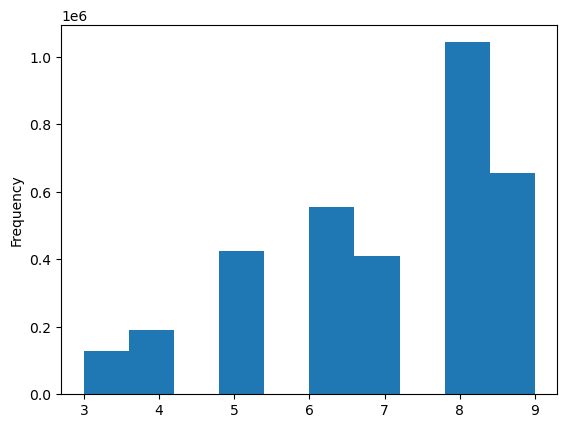

In [5]:
%matplotlib inline
df.grade.plot.hist()
plt.show()

In [6]:
# Add abilities
MS_PATH = './data/abilities_2pl.rda'
rds = pyreadr.read_r(MS_PATH)
df_abilities = rds['abilities']
df_abilities['studentId'] = df_abilities['studentId'].astype(int)
df_abilities = df_abilities.rename(columns={'Ability': 'ability', 'Scale':'scale'})
df_abilities = df_abilities.loc[df_abilities.model == 'all_2_studentId_personpreds_itempreds_excludeBadSessions_onlyClosed']
df_abilities['day'] = df_abilities['timestamp'].dt.strftime('%Y-%m-%d')
df_abilities = df_abilities[['studentId', 'day', 'scale', 'ability']]

df.set_index(['studentId', 'scale', 'day'], inplace=True)
df_abilities.set_index(['studentId', 'scale', 'day'], inplace=True)
df = df.join(df_abilities, how='left').reset_index()
#df = df.merge(df_abilities, on=['studentId', 'scale', 'day'], how='left').reset_index()
EDGE_COLS = EDGE_COLS + ['ability']
COLS = STUDENT_COLS + ITEM_COLS + EDGE_COLS

print(COLS)

['studentId', 'motherTongue', 'Gender', 'code', 'scale', 'matrix', 'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score', 'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId', 'ability']


In [ ]:
# student attributes    
df_student = df[STUDENT_COLS].groupby(by=['studentId']).agg(mymode).reset_index() 

# item attributes
df_item = df[ITEM_COLS].groupby(by=['code']).agg(mymode).reset_index()

#df = df.merge(df_student, on='studentId', suffixes = ('_x', ''))

df.set_index('studentId', inplace=True)
df_student.set_index('studentId', inplace=True)
df = df.join(df_student, how='inner', lsuffix ='_x').reset_index()

In [ ]:
df.columns

In [ ]:
if DROPNA:
    df = df[COLS].dropna(subset=MAINCOLS).reset_index()
#print(df.shape)
print(df.isnull().sum())

In [ ]:
df_aux = df.drop(columns=['index']).drop_duplicates(['studentId', 'assessmentId']).sort_values(['studentId', 'timestamp'], ascending=True)
#previous_timestamps = df_aux.groupby(['studentId']).cumcount().reset_index()
df_aux['previous_sessions'] = df_aux.set_index(['studentId']).groupby(level=[0]).cumcount().values
df_aux['years_from_start'] = df_aux.groupby('studentId', group_keys=False).age.apply(lambda x: x - x.min()).values
df_aux['pace'] = df_aux['years_from_start']/(df_aux['previous_sessions'] + 1e-6)
df_aux['frequency'] = 1/(df_aux['pace'] + 1e-6)

In [ ]:
df.set_index(['studentId', 'assessmentId'], inplace=True)
df_aux.set_index(['studentId', 'assessmentId'], inplace=True)
df = df.join(df_aux[['frequency', 'previous_sessions', 'years_from_start']], how='left').reset_index()
EDGE_COLS = EDGE_COLS + ['frequency', 'previous_sessions', 'years_from_start']
COLS = STUDENT_COLS + ITEM_COLS + EDGE_COLS

In [ ]:
df.head()

In [ ]:
# matrize or topics sampling 
# sample one case which has 

def sample_group(df, columns):
    print("* Sampling group")
    if columns == []:
        return df
    columns = ['studentId','assessmentId'] + columns
    df = df.groupby(by=columns).sample(1).reset_index()
    print(df.shape)
    return df

def remove_min(df, MINSTUDENTS, MINITEMS, nsubs=0, balanced=True):
    print("* Removing min")
    print(df.shape)
    # remove items with too few students
    df_student_item = df[['studentId', 'code']].drop_duplicates()

    nstudents = df_student_item.groupby('code').count()
    items_enough_students = nstudents.index[nstudents.studentId > MINSTUDENTS].tolist()

    df = df.loc[df.code.isin(items_enough_students)]

    # remove students with too few items
    df_student_item = df[['studentId', 'code']].drop_duplicates()

    nitems = df_student_item.groupby('studentId').count()
    students_enough_items = nitems.index[nitems.code > MINITEMS].tolist()

    df = df.loc[df.studentId.isin(students_enough_items)]
    
    if nsubs > 0:
        if balanced:
            n_grades = df['grade'].nunique()
            df_list = []
            for grade in df['grade'].unique():
                df_grade = df.loc[df.grade == grade]['studentId'].unique()
                n_subs_grade = np.minimum(nsubs//n_grades, len(df_grade))                 
                studentIds = np.random.choice(df_grade, n_subs_grade, replace=False)    
                df_list.append(df.loc[df.studentId.isin(studentIds)])
                
            df = pd.concat(df_list)
        
        else:
            studentIds = np.random.choice(df['studentId'].unique(), nsubs, replace=False)
            df = df.loc[df.studentId.isin(studentIds)]
            
    print(df.columns)
    print(df.studentId.nunique())
    print(df.matrix.nunique())
    print(df.topic.nunique())    
    print(df.shape)
    return df
        
def get_attributes(df):
    print("* Getting attributes")
    # edge attributes
    df_edge = df[COLS].groupby(by=['studentId', 'code']).agg(mymode).reset_index() 

    # student attributes    
    df_student = df[STUDENT_COLS].loc[df.studentId.isin(df_edge.studentId)].groupby(by=['studentId']).agg(mymode).reset_index() 

    # item attributes
    df_item = df[ITEM_COLS].loc[df.code.isin(df_edge.code)].groupby(by=['code']).agg(mymode).reset_index()
    
    df_edge = df[COLS].groupby(by=['studentId', 'code']).agg(mymode).reset_index()
    
    # recode
    le_student = LabelEncoder()
    le_item = LabelEncoder()

    le_student.fit(df_student['studentId'])
    le_item.fit(df_item['code'])

    df_edge['studentId'] = le_student.transform(df_edge['studentId'])
    df_edge['code'] = le_item.transform(df_edge['code'])

    df_student['studentId'] = le_student.transform(df_student['studentId'])
    df_item['code'] = le_item.transform(df_item['code'])
        
    print(df_student)
    print(df_item)
    print(df_edge)
    
    return df_edge, df_item, df_student

def process_data(df, columns, OUT_PATH, NSUBS=0):    
    if columns == []:
        suffix = 'full'
    else:
        suffix = '_'.join(columns)
        
    if NSUBS > 0:
        suffix = suffix + f"_{NSUBS}"
    
    #print(df)
    df = sample_group(df, columns)
    df = remove_min(df, MINSTUDENTS, MINITEMS, NSUBS)
    df_edge, df_item, df_student = get_attributes(df)
    
    plt.figure()
    df_edge.grade.plot.hist()
    plt.show()
    
    df_edge.to_csv(f"{OUT_PATH}_{suffix}.csv")
    print(f"Saving to {OUT_PATH}_{suffix}.csv")
    

In [ ]:
%matplotlib inline
    
OUT_PATH = './data/mindsteps_set'

process_data(df, [], OUT_PATH)
process_data(df, ['topic'], OUT_PATH)
process_data(df, ['matrix'], OUT_PATH)
#process_data(df, ['matrix','topic'], OUT_PATH)

#if TEST:
#    OUT_PATH = OUT_PATH + '_test'
#else:
#    process_data(df, [], OUT_PATH, NSUBS)
#    process_data(df, ['topic'], OUT_PATH, NSUBS)
#    process_data(df, ['matrix'], OUT_PATH, NSUBS)
#    process_data(df, ['matrix','topic'], OUT_PATH, NSUBS)